In [ ]:
# ----------------------- Mount Drive -----------------------
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ----------------------- Cell 1: Setup and Imports -----------------------
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import cv2
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam


In [ ]:
# ----------------------- Paths and Parameters -----------------------
# Paths to folders
train_dir = "/content/drive/MyDrive/flowers/train"
test_dir = "/content/drive/MyDrive/flowers/test"
val_dir = "/content/drive/MyDrive/flowers/valid"
image_size = (128, 128)
batch_size = 32

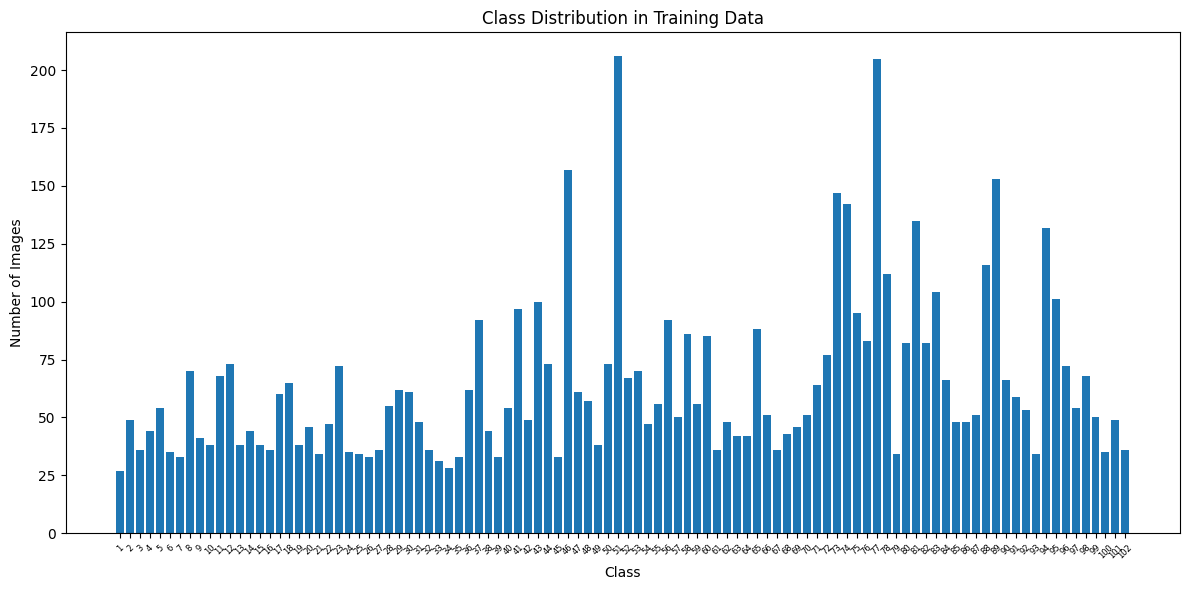

In [ ]:
# ----------------------- Cell 3: Data Exploration -----------------------
def explore_data(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    # تحويل أسماء الفئات إلى أرقام لترتيبها (إذا كانت كلها أرقام)
    sorted_classes = sorted(class_counts.keys(), key=lambda x: int(x))

    sorted_counts = [class_counts[class_name] for class_name in sorted_classes]

    plt.figure(figsize=(12, 6))
    plt.bar(sorted_classes, sorted_counts)
    plt.xticks(rotation=45, fontsize=6)  # تصغير الخط لتحسين العرض
    plt.title("Class Distribution in Training Data")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

explore_data(train_dir)

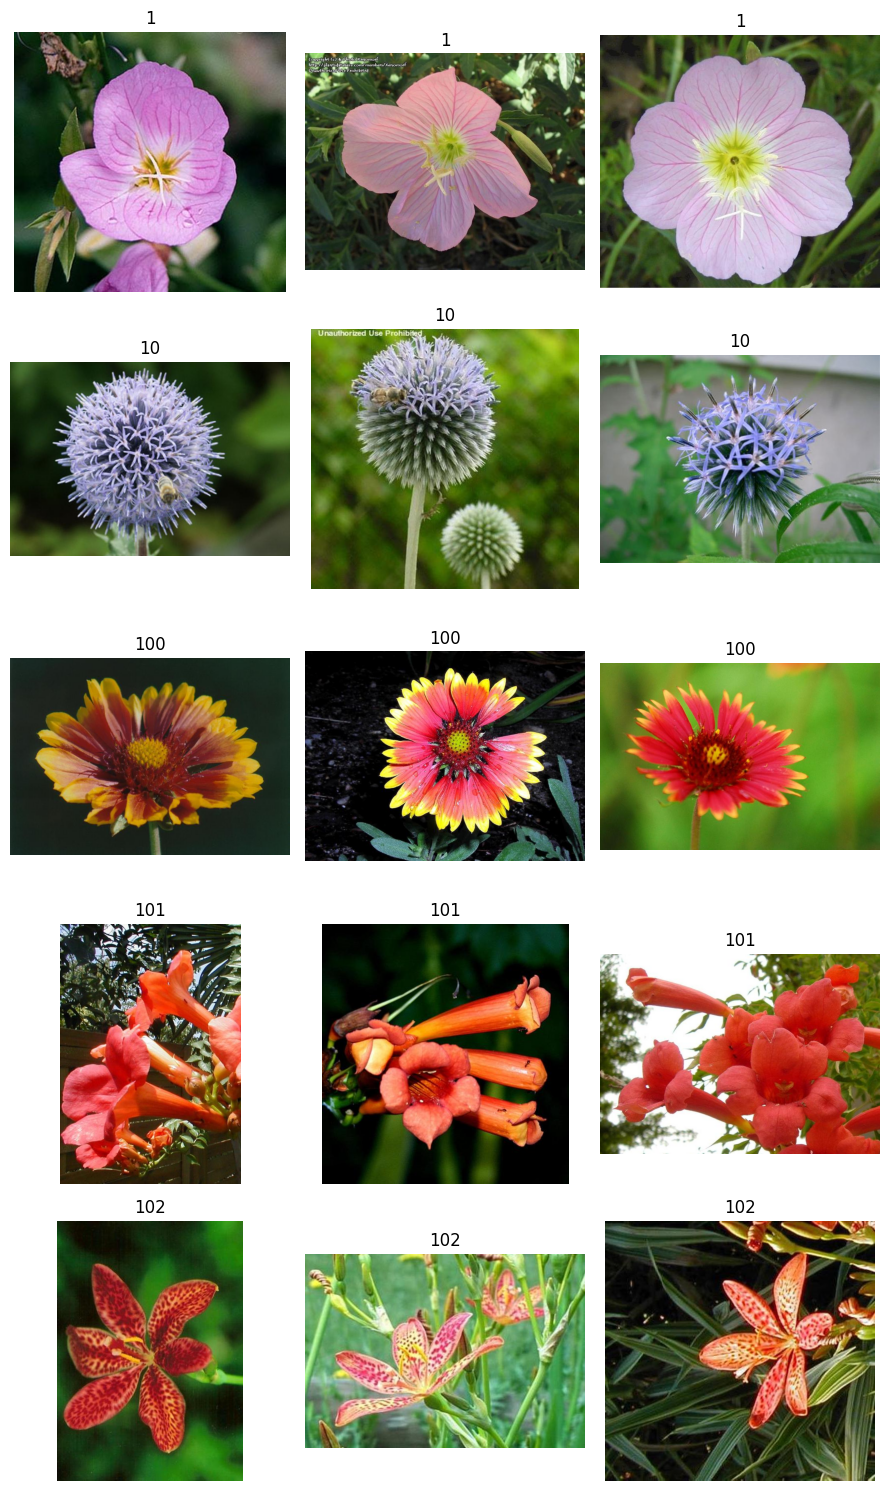

In [ ]:
# ----------------------- Cell 4: Show Sample Images -----------------------
def show_sample_images(directory, num_classes=5, samples_per_class=3):
    class_names = sorted(os.listdir(directory))[:num_classes]
    plt.figure(figsize=(samples_per_class * 3, num_classes * 3))
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        images = os.listdir(class_path)[:samples_per_class]
        for i, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = mpimg.imread(img_path)
            plt.subplot(num_classes, samples_per_class, class_idx * samples_per_class + i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)
    plt.tight_layout()
    plt.show()

show_sample_images(train_dir)

In [ ]:
# ----------------------- Cell 5: Data Generators -----------------------
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = data_augmentation.flow_from_directory(train_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical')
val_gen = val_test_datagen.flow_from_directory(val_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical')
test_gen = val_test_datagen.flow_from_directory(test_dir, target_size=image_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

print("Class indices:", train_gen.class_indices)


Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.
Found 819 images belonging to 102 classes.
Class indices: {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86,

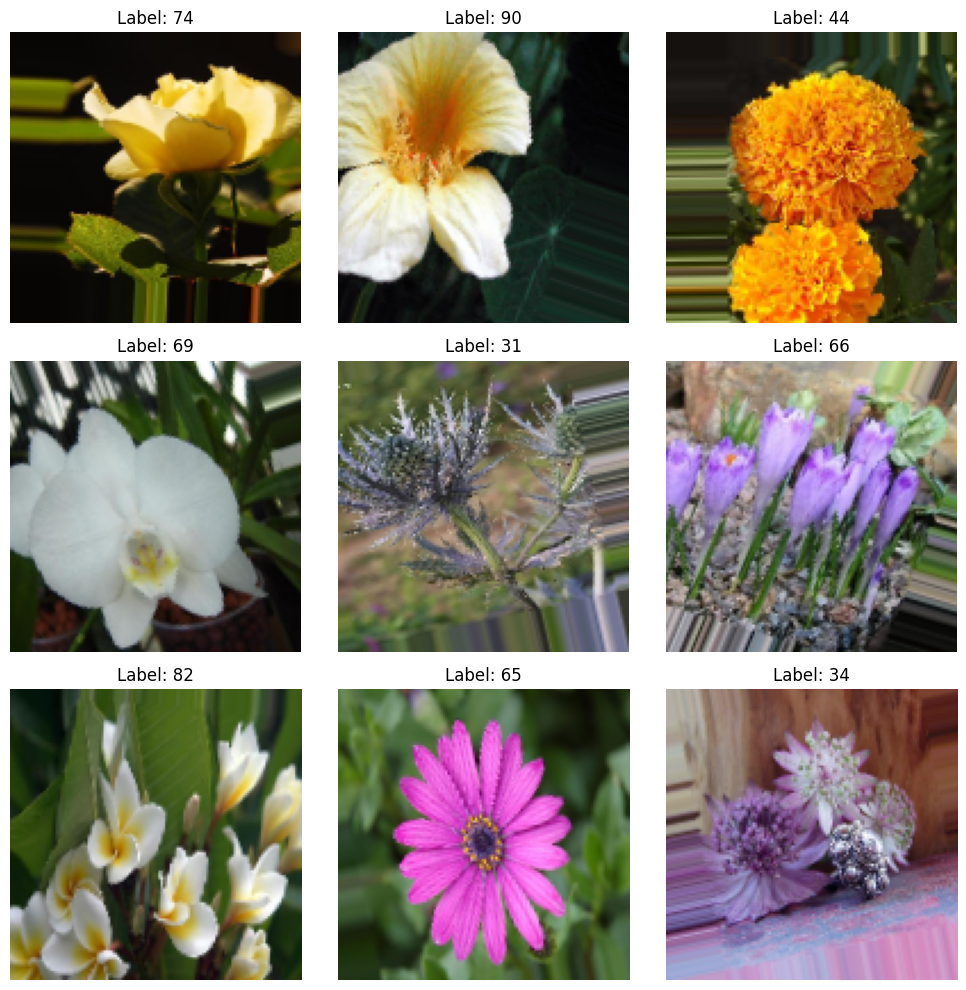

In [ ]:
# ----------------------- Cell 6: Show Augmented Images -----------------------
def plot_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(train_gen)


In [ ]:

# ----------------------- Cell 7: Training Utilities -----------------------
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_generator, model_name):
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    print(f"\nClassification Report - {model_name}")
    class_labels = list(test_generator.class_indices.keys())
    print(classification_report(y_true, y_pred, target_names=class_labels))
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=class_labels).plot(xticks_rotation=90)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

def evaluate_svm(y_true, y_pred, class_labels, model_name):
    print(f"\nClassification Report - {model_name}")
    print(classification_report(y_true, y_pred, target_names=class_labels))
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=class_labels).plot(xticks_rotation=90)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 1958s 10s/step - accuracy: 0.0381 - loss: 4.5400 - val_accuracy: 0.0672 - val_loss: 4.0056
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.0697 - loss: 4.0935 - val_accuracy: 0.1247 - val_loss: 3.5797
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.0950 - loss: 3.7858 - val_accuracy: 0.1614 - val_loss: 3.3699
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.1271 - loss: 3.5899 - val_accuracy: 0.1895 - val_loss: 3.1788
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.1478 - loss: 3.4221 - val_accuracy: 0.2384 - val_loss: 3.0556
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.1792 - loss: 3.2546 - val_accuracy: 0.2787 - val_loss: 2.8592
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.1879 - loss: 3.2320 - val_accuracy: 0.2653 - val_loss: 2.8205
Epoch 8/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.2200 - loss: 3.0774 - val_ac

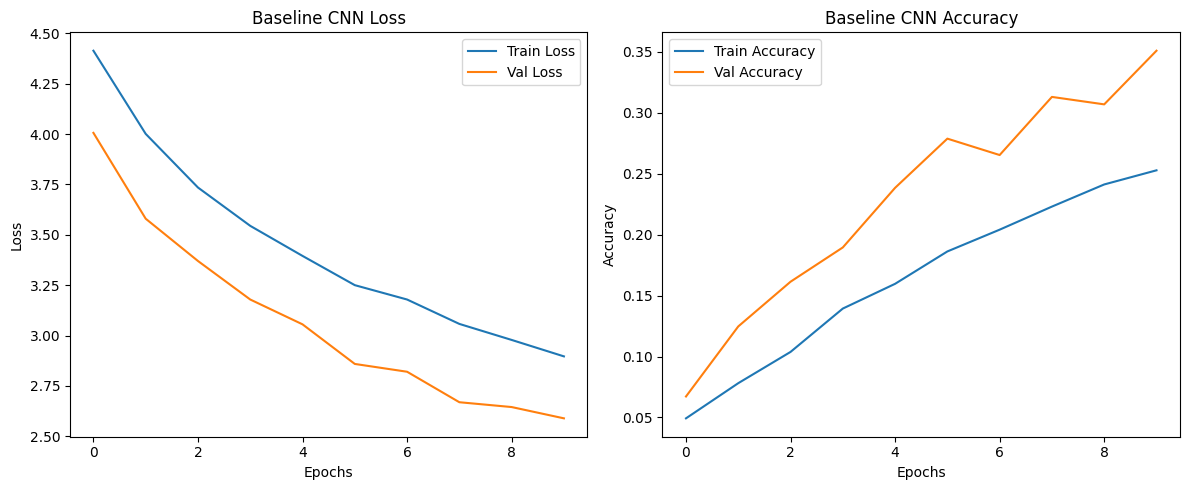

26/26 ━━━━━━━━━━━━━━━━━━━━ 215s 9s/step

Classification Report - Baseline CNN
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         3
         100       1.00      0.12      0.22         8
         101       0.27      0.75      0.40         4
         102       0.40      0.33      0.36         6
          11       0.00      0.00      0.00         9
          12       0.20      0.44      0.28         9
          13       0.14      0.17      0.15         6
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         3
          17       0.78      0.78      0.78         9
          18       0.00      0.00      0.00         6
          19       0.00      0.00      0.00         7
           2       0.50      0.20      0.29         5
          20       0.00      0.00      0.00         3
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


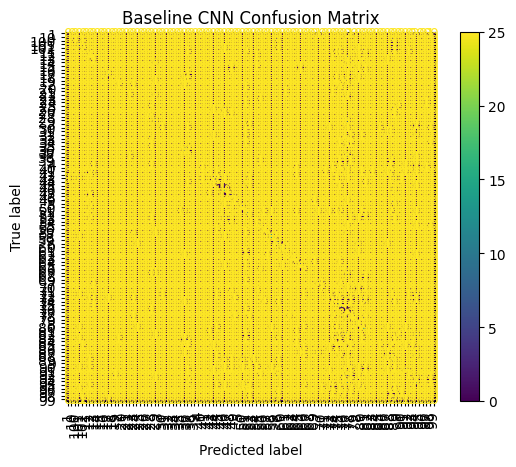

In [ ]:

# ----------------------- Cell 8: Baseline CNN Model -----------------------
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), #parameter 23
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(train_gen.num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
cnn_history = cnn_model.fit(train_gen, validation_data=val_gen, epochs=10)
plot_training_history(cnn_history, "Baseline CNN")
evaluate_model(cnn_model, test_gen, "Baseline CNN")
cnn_model.save("cnn_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - accuracy: 0.0296 - loss: 4.5617 - val_accuracy: 0.0868 - val_loss: 3.9935
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.0756 - loss: 4.0281 - val_accuracy: 0.1125 - val_loss: 3.6977
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.0988 - loss: 3.7603 - val_accuracy: 0.1797 - val_loss: 3.3223
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.1280 - loss: 3.5483 - val_accuracy: 0.1883 - val_loss: 3.1673
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.1443 - loss: 3.4478 - val_accuracy: 0.2592 - val_loss: 2.9646
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.1727 - loss: 3.2882 - val_accuracy: 0.2531 - val_loss: 2.8624
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.1968 - loss: 3.2057 - val_accuracy: 0.2543 - val_loss: 2.9078
Epoch 8/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.2112 - loss: 3.1058 - val_accu

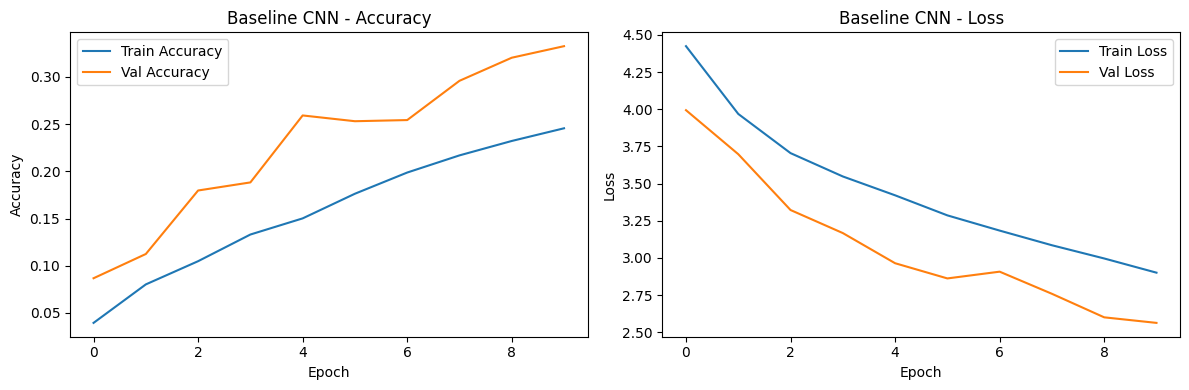

26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 449ms/step

Classification Report - Baseline CNN
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         3
         100       0.00      0.00      0.00         8
         101       0.00      0.00      0.00         4
         102       0.40      0.33      0.36         6
          11       0.00      0.00      0.00         9
          12       0.31      0.44      0.36         9
          13       0.20      0.17      0.18         6
          14       1.00      0.33      0.50         3
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         3
          17       0.57      0.44      0.50         9
          18       0.00      0.00      0.00         6
          19       0.00      0.00      0.00         7
           2       0.29      0.40      0.33         5
          20       0.00      0.00      0.00         3
 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


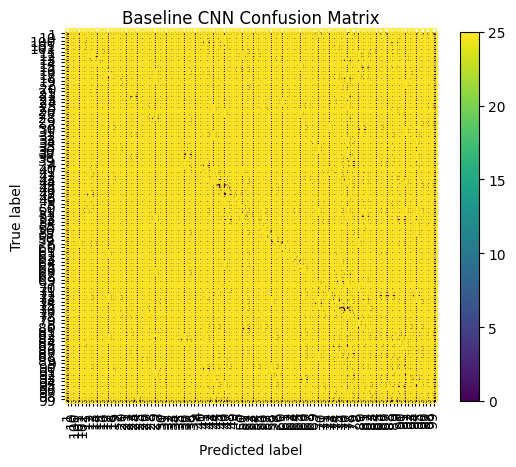

In [ ]:
import pandas as pd
import os

# ----------------------- Create Output Directory -----------------------
output_dir = "cnn_run_results"
os.makedirs(output_dir, exist_ok=True)

# ----------------------- Build and Train Model -----------------------
# cnn_model = build_cnn_model()
# cnn_history = cnn_model.fit(train_gen, validation_data=val_gen, epochs=10)

# ----------------------- Save Training History to CSV -----------------------
history_df = pd.DataFrame(cnn_history.history)
history_csv_path = os.path.join(output_dir, "cnn_training_history.csv")
history_df.to_csv(history_csv_path, index=False)

# ----------------------- Save Plot to PNG -----------------------
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plot_path = os.path.join(output_dir, f"{title.replace(' ', '_').lower()}_plot.png")
    plt.savefig(plot_path)
    plt.show()

plot_training_history(cnn_history, "Baseline CNN")

# ----------------------- Evaluate and Save Model -----------------------
evaluate_model(cnn_model, test_gen, "Baseline CNN")

# Save model
model_path = os.path.join(output_dir, "cnn_model.h5")
cnn_model.save(model_path)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1573s 8s/step - accuracy: 0.0323 - loss: 4.5570 - val_accuracy: 0.1394 - val_loss: 4.0773
Epoch 2/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1559s 8s/step - accuracy: 0.1093 - loss: 4.0730 - val_accuracy: 0.2115 - val_loss: 3.5008
Epoch 3/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1599s 8s/step - accuracy: 0.1724 - loss: 3.6209 - val_accuracy: 0.3020 - val_loss: 3.0475
Epoch 4/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1594s 8s/step - accuracy: 0.2050 - loss: 3.2812 - val_accuracy: 0.3778 - val_loss: 2.7657
Epoch 5/5
205/205 ━━━━━━━━━━━━━━━━━━━━ 1588s 8s/step - accuracy: 0.2476 - loss: 3.0670 - val_accuracy: 0.4071 - val_loss: 2.5674


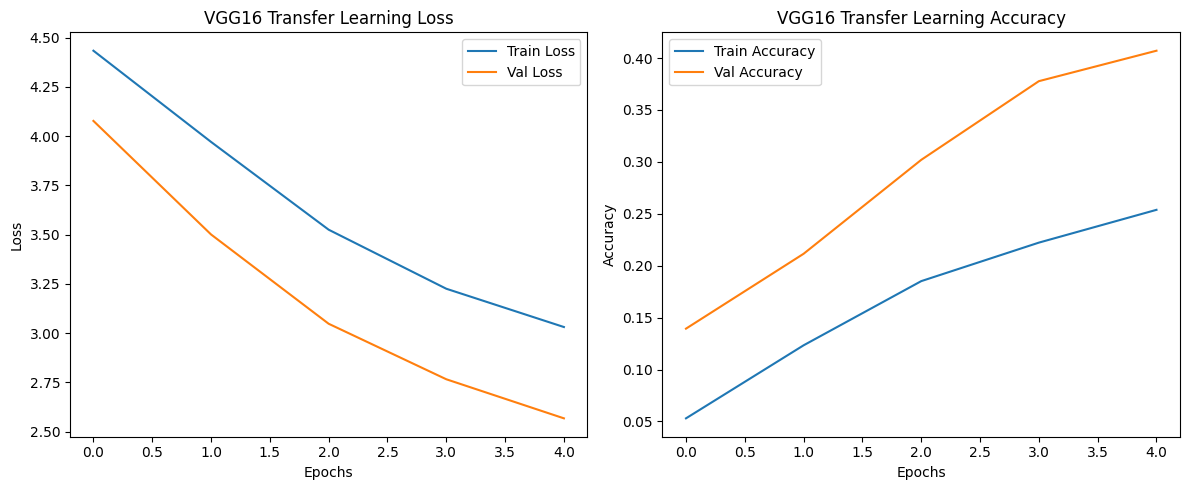

26/26 ━━━━━━━━━━━━━━━━━━━━ 176s 7s/step

Classification Report - VGG16 Transfer Learning
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
          10       0.60      1.00      0.75         3
         100       0.00      0.00      0.00         8
         101       0.00      0.00      0.00         4
         102       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         9
          12       0.28      0.56      0.37         9
          13       1.00      0.17      0.29         6
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         3
          17       1.00      0.44      0.62         9
          18       1.00      0.17      0.29         6
          19       0.00      0.00      0.00         7
           2       0.44      0.80      0.57         5
          20       0.00      0.00      0.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


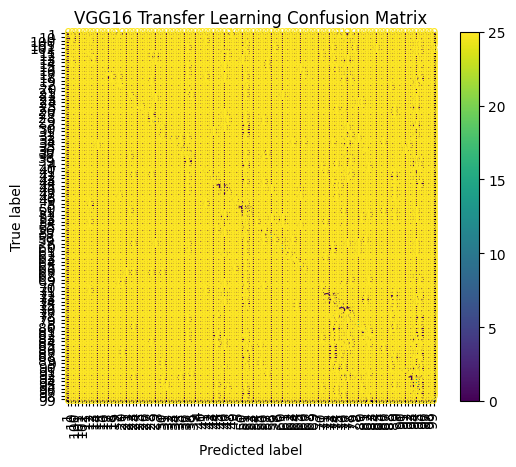

In [ ]:
# ----------------------- Cell 9: VGG16 Transfer Learning -----------------------
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in vgg_base.layers:
    layer.trainable = False

vgg_model = Sequential([
    vgg_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])
vgg_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
vgg_history = vgg_model.fit(train_gen, validation_data=val_gen, epochs=5)
plot_training_history(vgg_history, "VGG16 Transfer Learning")
evaluate_model(vgg_model, test_gen, "VGG16 Transfer Learning")
vgg_model.save("vgg_model.h5")


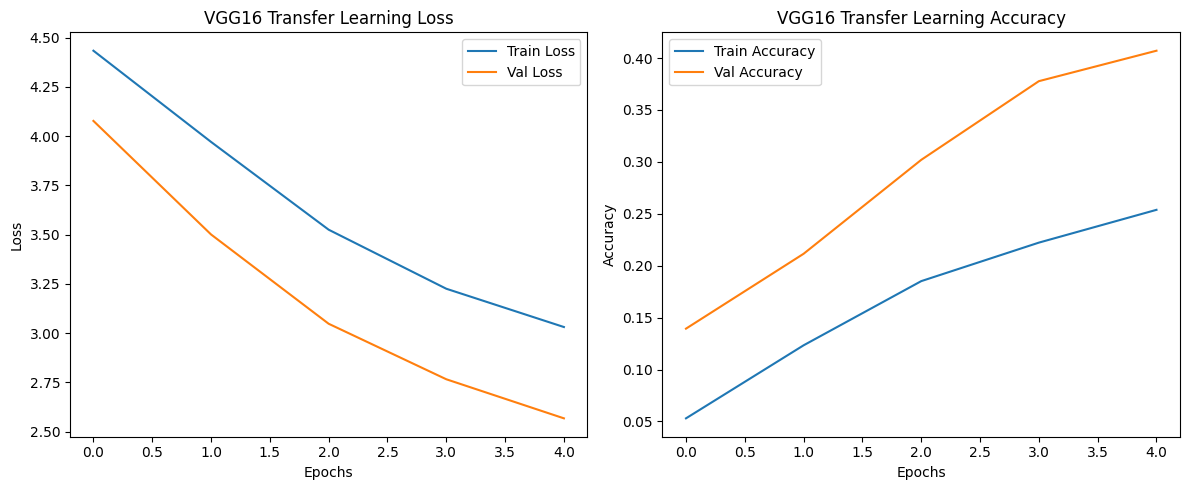

26/26 ━━━━━━━━━━━━━━━━━━━━ 167s 6s/step

Classification Report - VGG16 Transfer Learning
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
          10       0.60      1.00      0.75         3
         100       0.00      0.00      0.00         8
         101       0.00      0.00      0.00         4
         102       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         9
          12       0.28      0.56      0.37         9
          13       1.00      0.17      0.29         6
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         3
          17       1.00      0.44      0.62         9
          18       1.00      0.17      0.29         6
          19       0.00      0.00      0.00         7
           2       0.44      0.80      0.57         5
          20       0.00      0.00      0.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


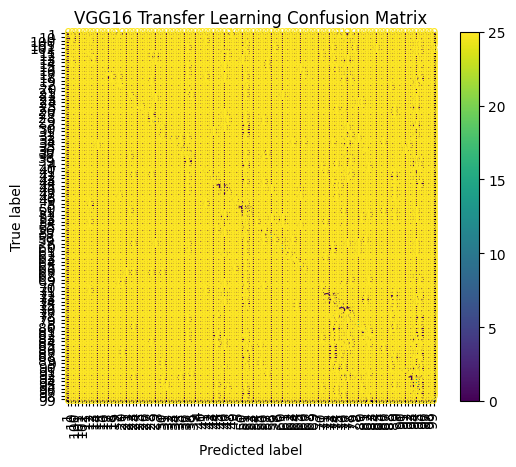

In [ ]:
import pandas as pd
import os

# ----------------------- Create Output Directory -----------------------
vgg_output_dir = "vgg_run_results"
os.makedirs(vgg_output_dir, exist_ok=True)

# ----------------------- Build and Train VGG16 Model -----------------------
# vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# for layer in vgg_base.layers:
#     layer.trainable = False

# vgg_model = Sequential([
#     vgg_base,
#     GlobalAveragePooling2D(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(train_gen.num_classes, activation='softmax')
# ])
# vgg_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# vgg_history = vgg_model.fit(train_gen, validation_data=val_gen, epochs=5)

# ----------------------- Save Training History to CSV -----------------------
vgg_history_df = pd.DataFrame(vgg_history.history)
vgg_history_csv_path = os.path.join(vgg_output_dir, "vgg_training_history.csv")
vgg_history_df.to_csv(vgg_history_csv_path, index=False)

# ----------------------- Save Plot to PNG -----------------------
plot_training_history(vgg_history, "VGG16 Transfer Learning")  # This function already saves the plot

# ----------------------- Evaluate and Save Model -----------------------
evaluate_model(vgg_model, test_gen, "VGG16 Transfer Learning")

vgg_model_path = os.path.join(vgg_output_dir, "vgg_model.h5")
vgg_model.save(vgg_model_path)



Classification Report - HOG + SVM
              precision    recall  f1-score   support

           1       0.14      0.14      0.14         7
          10       0.40      0.25      0.31         8
         100       0.20      0.08      0.12        12
         101       0.00      0.00      0.00        14
         102       0.00      0.00      0.00        11
          11       0.19      0.25      0.21        12
          12       0.16      0.25      0.19        12
          13       0.25      0.14      0.18         7
          14       0.21      0.38      0.27         8
          15       0.60      0.23      0.33        13
          16       0.00      0.00      0.00         6
          17       0.50      0.82      0.62        11
          18       0.17      0.09      0.12        11
          19       0.00      0.00      0.00         7
           2       0.50      1.00      0.67         3
          20       0.43      0.43      0.43         7
          21       0.43      0.60      0.50   

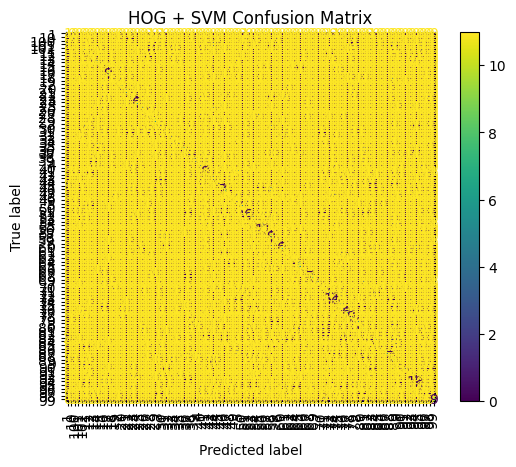

In [ ]:

# ----------------------- Cell 10: HOG + SVM -----------------------
def load_images_and_labels(directory, image_size):
    features = []
    labels = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path)[:100]:
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, image_size)
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    hog_feat = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
                    features.append(hog_feat)
                    labels.append(class_name)
    return np.array(features), np.array(labels)

hog_features, hog_labels = load_images_and_labels(train_dir, image_size)
le = LabelEncoder()
hog_labels_encoded = le.fit_transform(hog_labels)

X_train, X_val, y_train, y_val = train_test_split(hog_features, hog_labels_encoded, test_size=0.2, random_state=42)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

evaluate_svm(y_val, y_pred_svm, le.classes_, "HOG + SVM")

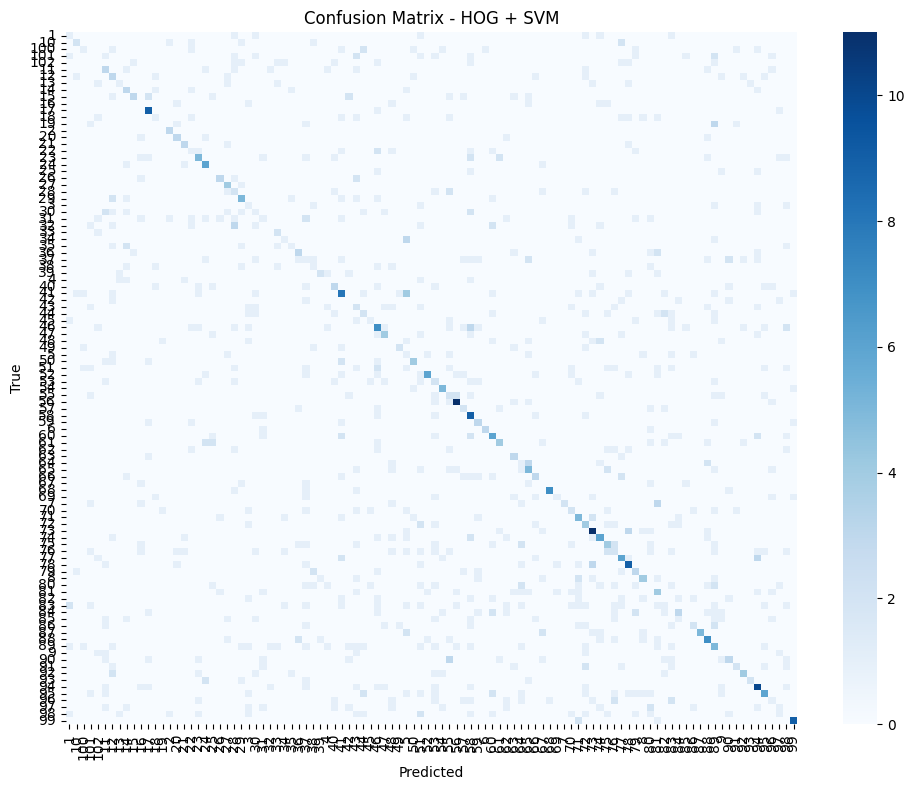


Classification Report - HOG + SVM
              precision    recall  f1-score   support

           1       0.14      0.14      0.14         7
          10       0.40      0.25      0.31         8
         100       0.20      0.08      0.12        12
         101       0.00      0.00      0.00        14
         102       0.00      0.00      0.00        11
          11       0.19      0.25      0.21        12
          12       0.16      0.25      0.19        12
          13       0.25      0.14      0.18         7
          14       0.21      0.38      0.27         8
          15       0.60      0.23      0.33        13
          16       0.00      0.00      0.00         6
          17       0.50      0.82      0.62        11
          18       0.17      0.09      0.12        11
          19       0.00      0.00      0.00         7
           2       0.50      1.00      0.67         3
          20       0.43      0.43      0.43         7
          21       0.43      0.60      0.50   

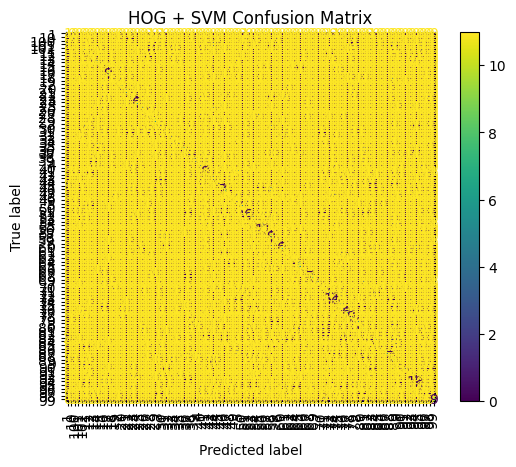

In [ ]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ----------------------- Create Output Directory -----------------------
hog_svm_output_dir = "hog_svm_results"
os.makedirs(hog_svm_output_dir, exist_ok=True)

# ----------------------- Load and Train HOG + SVM Model -----------------------
# hog_features, hog_labels = load_images_and_labels(train_dir, image_size)
# le = LabelEncoder()
# hog_labels_encoded = le.fit_transform(hog_labels)

# X_train, X_val, y_train, y_val = train_test_split(hog_features, hog_labels_encoded, test_size=0.2, random_state=42)
# svm_model = SVC(kernel='linear')
# svm_model.fit(X_train, y_train)

# # Save model
# svm_model_path = os.path.join(hog_svm_output_dir, "svm_model.joblib")
# joblib.dump(svm_model, svm_model_path)

# ----------------------- Evaluate -----------------------
y_pred_svm = svm_model.predict(X_val)

# Save classification report
report = classification_report(y_val, y_pred_svm, target_names=le.classes_, output_dict=False)
report_path = os.path.join(hog_svm_output_dir, "classification_report.txt")
with open(report_path, "w") as f:
    f.write(classification_report(y_val, y_pred_svm, target_names=le.classes_))

# Save confusion matrix plot
cm = confusion_matrix(y_val, y_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=le.classes_, yticklabels=le.classes_, annot=False, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - HOG + SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
cm_plot_path = os.path.join(hog_svm_output_dir, "confusion_matrix.png")
plt.savefig(cm_plot_path)
plt.show()

# Custom evaluation function call (if needed)
evaluate_svm(y_val, y_pred_svm, le.classes_, "HOG + SVM")


In [ ]:
# ----------------------- Cell 11: Object Tracking with OpenCV -----------------------
# ----------------------- Cell 11: Object Tracking with OpenCV -----------------------
def detect_and_track_fruit(video_path, model_path, class_names):
    import cv2
    import numpy as np
    from tensorflow.keras.models import load_model

    model = load_model(model_path)
    image_size = (224, 224)

    cap = cv2.VideoCapture("/content/drive/MyDrive/flowers/855867-hd_1920_1080_30fps.mp4")
    tracker = None
    tracking = False
    bbox = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # في أول إطار أو إذا لم يكن هناك تتبع نشط
        if not tracking:
            resized = cv2.resize(frame, image_size)
            normalized = resized / 255.0
            pred = model.predict(np.expand_dims(normalized, axis=0))[0]
            class_id = np.argmax(pred)
            label = class_names[class_id]

            # هنا يمكنك أن تطلب من المستخدم رسم صندوق أو تستخدم كاشف كائن لرسم bbox
            bbox = cv2.selectROI("Select Object", frame, fromCenter=False)
            cv2.destroyWindow("Select Object")

            tracker = cv2.TrackerKCF_create()
            tracker.init(frame, bbox)
            tracking = True
        else:
            success, bbox = tracker.update(frame)
            if success:
                x, y, w, h = map(int, bbox)
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(frame, f"Tracking: {label}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
            else:
                tracking = False

        cv2.imshow("Fruit Tracker", frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()






In [ ]:
!sudo apt update
!sudo apt install libgtk2.0-dev pkg-config
!pip uninstall opencv-python
!pip install opencv-python-headless
!pip install opencv-python
!pip install opencv-python-headless
!pip install opencv-python


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,722 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,932 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,901

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 889.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyt

100%|██████████| 6.25M/6.25M [00:00<00:00, 50.4MB/s]



0: 640x640 1 potted plant, 417.1ms
Speed: 6.7ms preprocess, 417.1ms inference, 30.6ms postprocess per image at shape (1, 3, 640, 640)


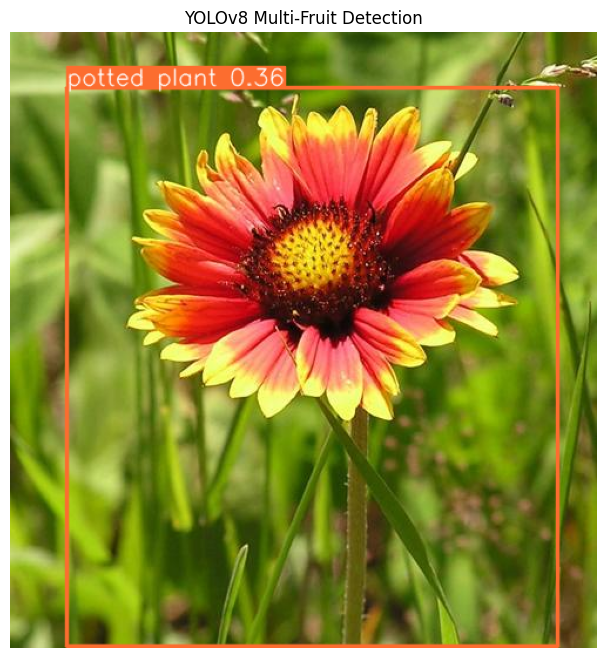


Detected objects:
 - potted plant: 0.36


In [ ]:
# ----------------------- YOLOv8 Object Detection -----------------------
!pip install -q ultralytics
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load model
yolo_model = YOLO('yolov8n.pt')

# Input image path
img_path = '/content/drive/MyDrive/flowers/test/100/image_07926.jpg'
frame = cv2.imread(img_path)

# Validate the image
if frame is None:
    raise ValueError(f"Image not found at given path: {img_path}")

# Run detection
results = yolo_model(frame)

# Annotate image
annotated = results[0].plot()
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

# Show the result with bounding boxes
plt.figure(figsize=(10, 8))
plt.imshow(annotated_rgb)
plt.axis('off')
plt.title("YOLOv8 Multi-Fruit Detection")
plt.show()

# Print all detections
print("\nDetected objects:")
for box in results[0].boxes:
    cls_id = int(box.cls[0])
    conf = float(box.conf[0])
    class_name = yolo_model.model.names[cls_id]
    print(f" - {class_name}: {conf:.2f}")


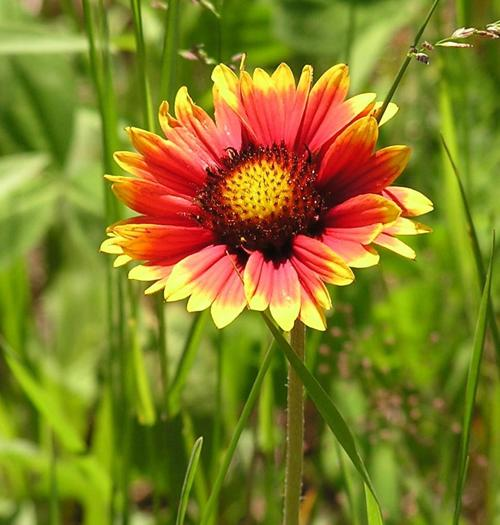

In [ ]:
from google.colab.patches import cv2_imshow
#cv2.imshow("Window", frame) # This line is causing the error

cv2_imshow(frame)  # Use cv2_imshow instead to display in Colab